In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import utilities as util

# Compare different Correlated Models

In [2]:
n_init = 3  # number of initial samples
n_run = 2  # number of runs
n_step = 5  # number of steps for BO
config = "offset_calibration"  # configuration of the prior mean
acq_name = "EI"
n_epochs = [10]  # which correlated models to compare

data, param = {}, {}
d = torch.load("BO/constant_prior/{}/constant.pt".format(acq_name))
data["constant"] = util.running_max(d["y"].squeeze())
for n_epoch in n_epochs:
    d = torch.load("BO/{}/{}/ep={:d}.pt".format(config, acq_name, n_epoch))
    data["ep={:d}".format(n_epoch)] = util.running_max(d["y"].squeeze())
    p_dict = {}
    for k, v in d.items():
        if k not in ["x", "y"]:
            p_dict[k] = v
    param["ep={:d}".format(n_epoch)] = p_dict
correlations = torch.load("corr_models/correlations.pt")
maes = torch.load("corr_models/maes.pt") * 1e3  # in mm

In [3]:
# calculate statistics
confidence_level = 0.9
median = torch.empty((len(n_epochs) + 1, n_init + n_step))
confidence = torch.empty((len(n_epochs) + 1, 2, n_init + n_step))

for i in range(len(n_epochs) + 1):
    if i == 0:
        k = "constant"
    else:
        k = "ep={:d}".format(n_epochs[i - 1])
    median[i, :] = torch.median(data[k], dim=0)[0]
    q = (1 - confidence_level) / 2.0
    confidence[i, 0, :] = torch.quantile(data[k], q=q, dim=0)
    confidence[i, 1, :] = torch.quantile(data[k], q=1-q, dim=0)

In [4]:
# labels, units, start index
obj_name = "Negative Transverse Beam Size"
obj_factor = 1e3
obj_unit = "(mm)"

start_idx = n_init - 1
x = torch.arange(0, n_step + n_init - start_idx)
median *= obj_factor
confidence *= obj_factor

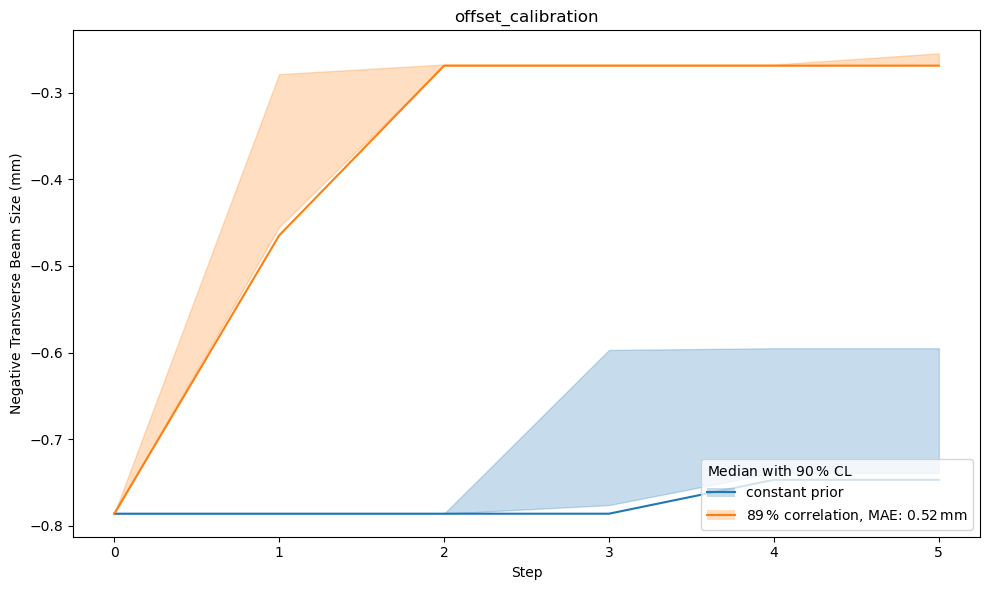

In [5]:
# create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
legend_handles, legend_labels = [], []
for i in range(len(n_epochs) + 1):
    if i == 0:
        label = "constant prior"
    else:
        label = "{:.0f}$\,$% correlation, MAE: {:.2f}$\,$mm".format(100 * correlations[n_epochs[i - 1] - 1], 
                                                              maes[n_epochs[i - 1] - 1])
    p1 = ax.plot(x, median[i, start_idx:], "C{:d}-".format(i), label=label)
    ax.fill_between(x, confidence[i, 0, start_idx:], confidence[i, 1, start_idx:], 
                    color="C{:d}".format(i), alpha=0.25)
    p2 = ax.fill([], [], color="C{:d}".format(i), linewidth=0, alpha=0.25)
    legend_handles.append((p2[0], p1[0]))
    legend_labels.append(label)

ax.set_title(config)
ax.set_xlabel("Step")
ax.set_ylabel("{} {}".format(obj_name, obj_unit))
ax.legend(legend_handles, legend_labels, loc=4, alignment="left", 
          title="Median with {:.0f}$\,$% CL".format(100 * confidence_level))
fig.tight_layout()

In [6]:
# calculate statistics
confidence_level = 0.9
x = torch.arange(0, n_step)
start_idx = 0
median = {}
c_lb, c_ub = {}, {}

for i in range(len(n_epochs)):
    k = "ep={:d}".format(n_epochs[i - 1])
    if param[k]:
        median[k], c_lb[k], c_ub[k] = {}, {}, {}
        for key, value in param[k].items():
            median[k][key] = torch.median(value, dim=0)[0].detach()
            q = (1 - confidence_level) / 2.0
            c_lb[k][key] = torch.quantile(value, q=q, dim=0).detach()
            c_ub[k][key] = torch.quantile(value, q=1-q, dim=0).detach()

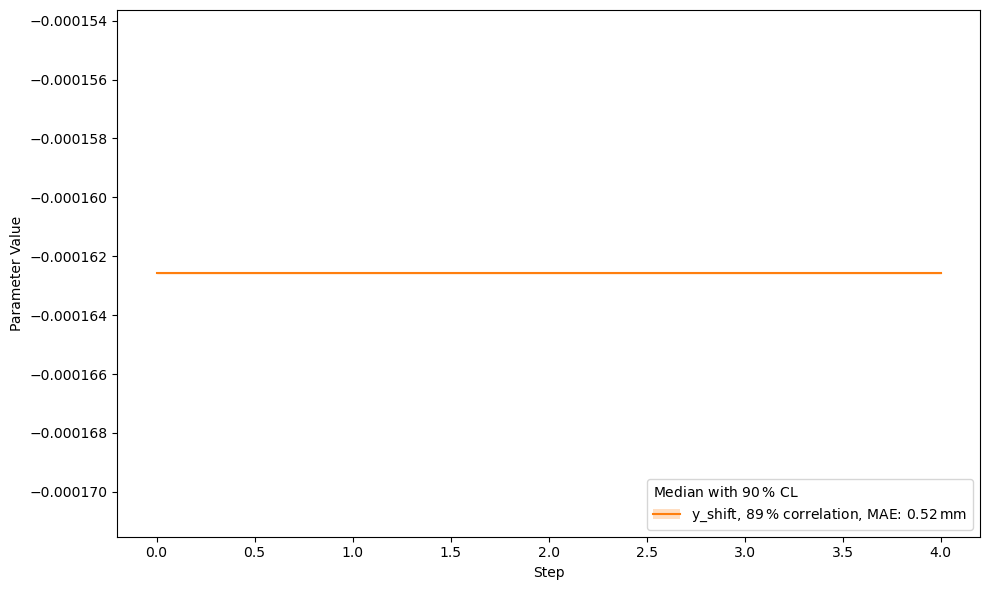

In [7]:
# create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
legend_handles, legend_labels = [], []
for i in range(len(n_epochs)):
    label = "{:.0f}$\,$% correlation, MAE: {:.2f}$\,$mm".format(100 * correlations[n_epochs[i] - 1], 
                                                          maes[n_epochs[i] - 1])
    k = "ep={:d}".format(n_epochs[i - 1])
    for key, value in median[k].items():
        label = key + ", " + label
        p1 = ax.plot(x, value[start_idx:], "C{:d}-".format(i+1), label=label)
        ax.fill_between(x, c_lb[k][key][start_idx:], c_ub[k][key][start_idx:], 
                        color="C{:d}".format(i+1), alpha=0.25)
        p2 = ax.fill([], [], color="C{:d}".format(i+1), linewidth=0, alpha=0.25)
        legend_handles.append((p2[0], p1[0]))
        legend_labels.append(label)

ax.set_xlabel("Step")
ax.set_ylabel("Parameter Value")
ax.legend(legend_handles, legend_labels, loc=4, alignment="left", 
          title="Median with {:.0f}$\,$% CL".format(100 * confidence_level))
fig.tight_layout()

# Compare different Prior Mean Configurations

In [8]:
n_init = 3  # number of initial samples
n_run = 2  # number of runs
n_step = 5  # number of steps for BO
configs = ["no_adjustments", "offset_calibration", "scale_calibration",
          "fixed_offset", "alternate", "flatten"]  # prior mean configurations to compare
acq_name = "EI"
n_epoch = 10

data = {}
d = torch.load("BO/constant_prior/{}/constant.pt".format(acq_name))
data["constant"] = util.running_max(d["y"].squeeze())
for c in configs:
    d = torch.load("BO/{}/{}/ep={:d}.pt".format(c, acq_name, n_epoch))
    data[c] = util.running_max(d["y"].squeeze())
correlations = torch.load("corr_models/correlations.pt")
maes = torch.load("corr_models/maes.pt") * 1e3  # in mm

In [9]:
# calculate statistics
confidence_level = 0.9
median = torch.empty((len(configs), n_init + n_step))
confidence = torch.empty((len(configs), 2, n_init + n_step))

for i, k in enumerate(configs):
    median[i, :] = torch.median(data[k], dim=0)[0]
    q = (1 - confidence_level) / 2.0
    confidence[i, 0, :] = torch.quantile(data[k], q=q, dim=0)
    confidence[i, 1, :] = torch.quantile(data[k], q=1-q, dim=0)

In [10]:
# labels and units
obj_name = "Negative Transverse Beam Size"
obj_factor = 1e3
obj_unit = "(mm)"

start_idx = n_init - 1
x = torch.arange(0, n_step + n_init - start_idx)
median *= obj_factor
confidence *= obj_factor

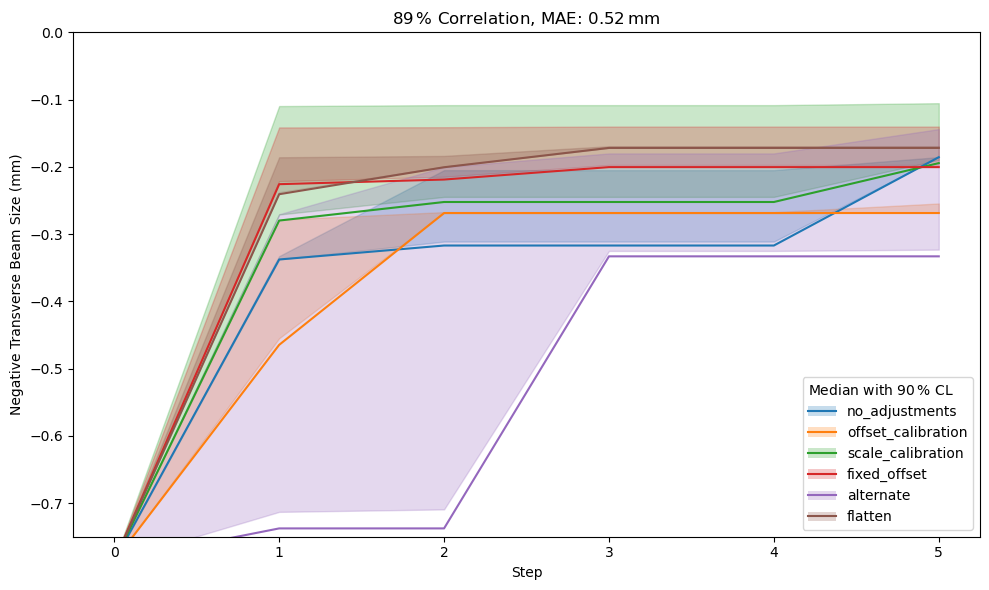

In [11]:
# create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
legend_handles, legend_labels = [], []
for i, k in enumerate(configs):
    p1 = ax.plot(x, median[i, start_idx:], "C{:d}-".format(i))
    ax.fill_between(x, confidence[i, 0, start_idx:], confidence[i, 1, start_idx:], 
                    color="C{:d}".format(i), alpha=0.25)
    p2 = ax.fill([], [], color="C{:d}".format(i), linewidth=0, alpha=0.25)
    legend_handles.append((p2[0], p1[0]))
    legend_labels.append(k)

ax.set_title("{:.0f}$\,$% Correlation, MAE: {:.2f}$\,$mm".format(100 * correlations[n_epoch - 1], 
                                                                 maes[n_epoch - 1]))
ax.set_xlabel("Step")
ax.set_ylabel("{} {}".format(obj_name, obj_unit))
ax.legend(legend_handles, legend_labels, loc=4, alignment="left", 
          title="Median with {:.0f}$\,$% CL".format(100 * confidence_level))
ax.set_ylim(-0.75, 0.0)
fig.tight_layout()